# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-92-telescope-spectrum-classification/297/overview/about

# Methodology:
1.

### Import all libraries required

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from imblearn.over_sampling import SMOTE

### Declare the path

In [2]:
train_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [18]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,20.1426,9.9778,2.2695,0.6022,0.3898,-4.7403,15.5312,-9.5154,17.646,56.5999,g


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,20.0335,14.284,2.4378,0.5328,0.2719,4.5573,-13.3556,3.5595,30.2511,173.673


In [19]:
train_df['class'] = train_df['class'].map({'g':1, 'h':0})

In [20]:
train_df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,52.994803,22.054462,2.819959,0.381813,0.215697,-4.931682,10.383390,0.304136,27.891382,193.044959,0.644400
std,42.849736,18.197425,0.473256,0.184880,0.111944,59.224209,51.401824,20.469221,26.194761,73.617054,0.478743
min,8.230400,0.000000,2.006500,0.013100,0.000300,-378.945700,-297.171700,-134.395000,0.000000,5.699800,0.000000
25%,24.209800,11.856275,2.471950,0.232775,0.127000,-20.685800,-12.849600,-10.779250,5.671400,142.300500,0.000000
50%,36.921900,17.029450,2.730500,0.355550,0.197600,3.472900,15.191900,0.000050,18.167900,192.861500,1.000000
75%,68.778050,24.525525,3.094100,0.508725,0.288950,23.336200,34.561725,10.854250,46.956725,239.579850,1.000000
max,334.177000,201.364000,5.323300,0.875700,0.675200,473.065400,238.321000,163.269700,90.000000,466.407800,1.000000


# Separate into dependent and independent features

In [21]:
train_X = train_df.drop('class', axis=1).copy()
train_y = train_df['class'].copy()
final_X = test_df.copy()

# Visualize the data

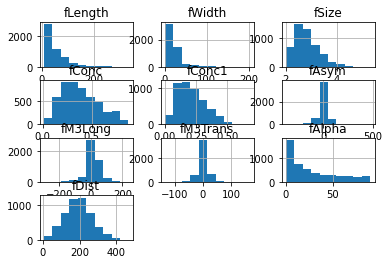

In [22]:
train_X.hist()
plt.show()

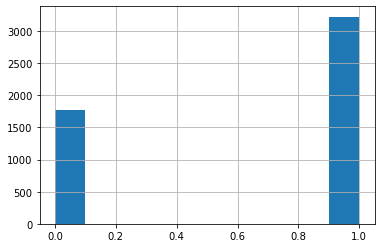

In [23]:
train_y.hist()
plt.show()

# The target classes are imbalanced, positive gamma cases are double of that of background

# Let's balance the data by carrying out minority oversampling

In [24]:
sm = SMOTE()
X, y=sm.fit_resample(train_X, train_y)

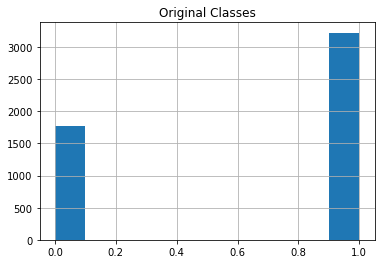

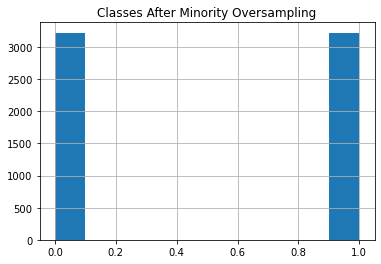

In [25]:
train_y.hist()
plt.title('Original Classes')
plt.show()
y.hist()
plt.title('Classes After Minority Oversampling')
plt.show()

# Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Cross Validation for model selection

# Define the models for classification

In [27]:
models = {'LOG': LogisticRegression(max_iter=500, solver='liblinear'),
         'LDA': LinearDiscriminantAnalysis(),
         'KNN': KNeighborsClassifier(n_jobs=4),
         'GNB': GaussianNB(),
         'DCT': DecisionTreeClassifier(),
         'SVM': SVC(),
          'RFC': RandomForestClassifier(n_jobs=4),
          'ADA': AdaBoostClassifier(),
         'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4),
        }

# Evaluate each model in turn using cross validation score on the training data. Metrics: Accuracy, Precision, Recall, F1 Score

In [28]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    print(f"{name}: Acc: {cv_results['test_accuracy'].mean():.3f},\
Prec: {cv_results['test_precision'].mean():.3f}, Rec: {cv_results['test_recall'].mean():.3f}, \
F1: {cv_results['test_f1'].mean():.3f}")

LOG: Acc: 0.759,Prec: 0.735, Rec: 0.810, F1: 0.770
LDA: Acc: 0.760,Prec: 0.724, Rec: 0.838, F1: 0.777
KNN: Acc: 0.787,Prec: 0.785, Rec: 0.790, F1: 0.787
GNB: Acc: 0.633,Prec: 0.588, Rec: 0.892, F1: 0.708
DCT: Acc: 0.798,Prec: 0.799, Rec: 0.796, F1: 0.798
SVM: Acc: 0.772,Prec: 0.739, Rec: 0.839, F1: 0.786
RFC: Acc: 0.865,Prec: 0.853, Rec: 0.882, F1: 0.867
ADA: Acc: 0.819,Prec: 0.821, Rec: 0.816, F1: 0.818
XGB: Acc: 0.867,Prec: 0.854, Rec: 0.885, F1: 0.869


# XGB & RFC Classifiers are promising

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f'Acc: {acc(y_test, preds):0.4f}, Prec: {ps(y_test, preds):0.4f},\
Rec; {rs(y_test, preds):0.4f}, F1: {f1(y_test, preds):0.4f}')

Acc: 0.8688, Prec: 0.8621,Rec; 0.8774, F1: 0.8697


# Confusion Matrix

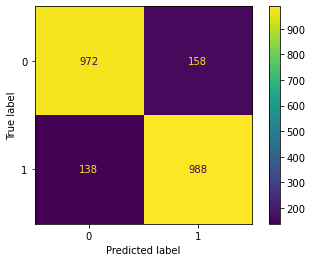

In [31]:
cm.from_predictions(y_test, preds)
plt.show()

# Classification Report

In [32]:
print(cr(y_test,preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1130
           1       0.86      0.88      0.87      1126

    accuracy                           0.87      2256
   macro avg       0.87      0.87      0.87      2256
weighted avg       0.87      0.87      0.87      2256



# Feature Importances

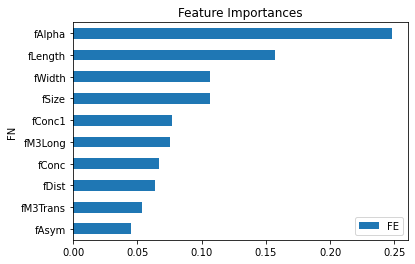

In [35]:
ax = pd.DataFrame(sorted(list(zip(model.feature_importances_, test_df.columns)), 
                        key=lambda x:x[0]), columns=['FE', 'FN'])
ax.set_index('FN', inplace=True)
ax.plot(kind='barh', title='Feature Importances')
plt.show()

# Predictions

In [37]:
final_X['preds'] = model.predict(final_X)
final_X['class'] = final_X['preds'].map({1:'g', 0:'h'})
final_X['class'].to_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/submission/sub1.csv', 
                   index=False)